In [34]:
import logging as lg
from keras.layers import Input, Dense
from keras.models import load_model,Model
from keras.callbacks import ModelCheckpoint,LambdaCallback
import json
from pathlib import Path
from keras.utils import to_categorical
from keras.datasets import mnist
import matplotlib.pyplot as plt 
from copy import deepcopy
import numpy as np
%matplotlib inline

In [41]:
verbose=True
RESULT_DIR=Path("result")
if verbose:
    lg.getLogger().setLevel(lg.INFO)
    lg.info("Verbose mode activated")

INFO:root:Verbose mode activated


In [42]:
class KerasNetInterface:
    original_layers={}
    
    def __init__(self,trained_epochs,result_dir,batch_size,valid_rate):
        self.result_dir=result_dir
        self.batch_size=batch_size
        self.valid_rate=valid_rate
        model_path=result_dir/f"{self.create_flag()}/model_{trained_epochs:02d}.h5"
        history_path=result_dir/f"{self.create_flag()}/history_{trained_epochs:02d}.json"
        
        model_path.parent.mkdir(exist_ok=True)
        if model_path.exists() and history_path.exists():
            self.trained_epochs=trained_epochs
            lg.info("Loading the trained model...")
            self.model=self.load_model(model_path)
            self.history=self.load_history(history_path)
            lg.info("Loaded.")
        else:
            lg.info("Not found such a trained model.")
            lg.info("Creating new model...")
            self.trained_epochs=0
            self.history={}
            self.model=self.construct()
            lg.info("Finished.")
    
    def load_model(self,model_path):
        return load_model(str(model_path),custom_objects=self.original_layers)


    def load_history(self,history_path):
        with history_path.open("r") as f:
            history=json.load(f)
        return history
    
    def fit(self, X, y, epochs):
        if self.trained_epochs >= epochs:
            lg.info(f"This model has already been traiend up to {self.trained_epochs} epochs")
            return
        callbacks=self.create_callbacks()
        self.model.fit(X,y,initial_epoch=self.trained_epochs,epochs=epochs,
                       batch_size=self.batch_size,callbacks=callbacks,validation_split=self.valid_rate)
        return self.history
   
    def save_model(self,save_path):
        self.model.save(str(save_path))
        
    def create_callbacks(self):
        model_path=self.result_dir / (self.create_flag()+"/model_{epoch:02d}.h5")
        mcp=ModelCheckpoint(str(model_path))
        hcp=LambdaCallback(on_epoch_end=lambda epoch,logs: self.save_history(epoch,logs))
        return [mcp,hcp]
    
    def save_history(self,epoch,logs):
        epoch+=1
        history_path=self.result_dir/ f"{self.create_flag()}/history_{epoch:02d}.json"
        if len(self.history)==0:
            self.history={k:[v] for k,v in logs.items()}
        else:
            for k,v in logs.items(): 
                self.history[k].append(v)
        with history_path.open("w") as f:
            json.dump(self.history,f)
        self.trained_epochs=epoch
     
    def plot_history(self,epoch):
        history_path=model.result_dir/model.create_flag()/f"history_{epoch:02d}.json"
        if history_path.exists():
            with history_path.open("r") as f:
                history=json.load(f)
            self.plot(history)
        else:
            raise Exception(f"Not found {history_path}")
            
    def evaluate(self,X,y):
        scores=self.model.evaluate(X,y)
        metrics_names=self.model.metrics_names
        return {metrics_names[i] : scores[i] for i in range(len(scores))}
    
    def create_flag(self):
        base_flag = f"{self.batch_size}_{self.valid_rate}"
        return f"{self.model_flag()}_{base_falg}"
    
    def plot(self):
        pass
    
    def predict(self):
        pass
            
    def construct(self):
        pass
    
    def model_flag(self):
        pass

In [43]:
class KerasClassifierInterface(KerasNetInterface):
    metrics=["accuracy"]
    def predict(self,X):
        return np.argmax(self.model.predict(X),axis=1)
    
    def predict_proba(self,X):
        return self.model.predict(X)    
    
    def plot(self,history):
        plt.plot(history['acc'])
        plt.plot(history['val_acc'])
        plt.title('model accuracy')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.legend(['acc', 'val_acc'], loc='lower right')
        plt.show()

        plt.plot(history['loss'])
        plt.plot(history['val_loss'])
        plt.title('model loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend(['loss', 'val_loss'], loc='lower right')
        plt.show()


class KerasRegressorInterface(KerasNetInterface):
    metrics=["mse"]
    def predict(self,X):
        return self.model.predict(X)

In [48]:
class MLPClassifier(KerasClassifierInterface):
    
    def __init__(self,result_dir,trained_epochs=0, valid_rate=0.3, batch_size=256, input_dim=784,
                             med1_dim=300,med2_dim=100,output_dim=10,activation="relu",
                             loss='categorical_crossentropy',optimizer='rmsprop'):
        self.loss=loss
        self.optimizer=optimizer
        self.input_dim=input_dim
        self.med1_dim=med1_dim
        self.med2_dim=med2_dim
        self.output_dim=output_dim
        self.activation=activation
        super().__init__(trained_epochs,result_dir,batch_size,valid_rate)
        
    def construct(self):
        inputs = Input(shape=(self.input_dim,))
        x = Dense(self.med1_dim, activation=self.activation)(inputs)
        x = Dense(self.med2_dim, activation=self.activation)(x)
        predictions = Dense(self.output_dim, activation='softmax')(x)
        model = Model(inputs=inputs, outputs=predictions)
        model.compile(optimizer=self.optimizer, loss=self.loss,metrics=self.metrics)
        return model
    
    def create_flag(self):
        return f"mlpc_{self.input_dim}_{self.med1_dim}_{self.med2_dim}_{self.output_dim}_{self.activation}"

In [49]:
def reshape_mnist(x,y):
    sample_num=x.shape[0]
    x=x.reshape(sample_num, -1)
    x= x.astype('float32')
    x /= 255
    y = to_categorical(y, 10)
    return x,y

In [50]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train,y_train=reshape_mnist(x_train,y_train)
x_test,y_test=reshape_mnist(x_test,y_test)

In [52]:
model=MLPClassifier(result_dir=RESULT_DIR)

INFO:root:Not found such a trained model.
INFO:root:Creating new model...
INFO:root:Finished.


In [53]:
history=model.fit(x_train,y_train,epochs=10)

Train on 42000 samples, validate on 18000 samples
Epoch 1/10
42000/42000 [==============================] - 1s 23us/step - loss: 0.3759 - acc: 0.8893 - val_loss: 0.4016 - val_acc: 0.8618
Epoch 2/10
42000/42000 [==============================] - 1s 17us/step - loss: 0.1534 - acc: 0.9545 - val_loss: 0.1634 - val_acc: 0.9496
Epoch 3/10
42000/42000 [==============================] - 1s 16us/step - loss: 0.1033 - acc: 0.9690 - val_loss: 0.1621 - val_acc: 0.9526
Epoch 4/10
42000/42000 [==============================] - 1s 17us/step - loss: 0.0732 - acc: 0.9775 - val_loss: 0.0993 - val_acc: 0.9697
Epoch 5/10
42000/42000 [==============================] - 1s 16us/step - loss: 0.0546 - acc: 0.9836 - val_loss: 0.1347 - val_acc: 0.9585
Epoch 6/10
42000/42000 [==============================] - 1s 16us/step - loss: 0.0413 - acc: 0.9874 - val_loss: 0.0959 - val_acc: 0.9712
Epoch 7/10
42000/42000 [==============================] - 1s 16us/step - loss: 0.0324 - acc: 0.9899 - val_loss: 0.0984 - val_acc

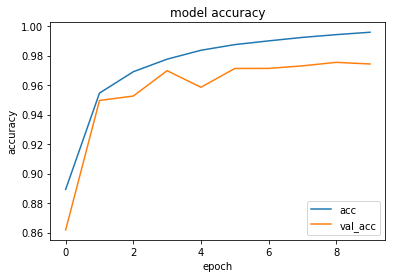

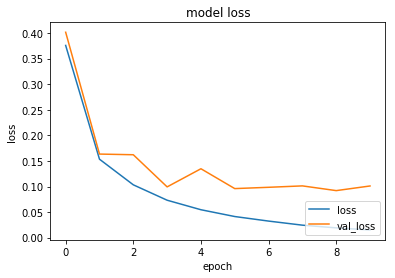

In [54]:
model.plot_history(epoch=10)

In [56]:
model.evaluate(x_test,y_test)

10000/10000 [==============================] - 0s 36us/step


{'loss': 0.07906778378458694, 'acc': 0.9803}